# 目标仿真模块说明
## 简介
观测目标仿真模块读取待仿真观测目标信息，根据参数选择不同的恒星模型生成观测目标或背景星辐照强度曲线，如果该目标周围有虚拟的行星，则根据行星反照率参数得到虚拟行星辐照强度。本模块基于pysynphot库开发。

本模块包括如下功能模块:
- 恒星光谱生成功能
- 行星光谱生成功能
- 目标位置功能
- 目标参数读取功能

## 恒星光谱生成

可使用star_photlam函数生成恒星光谱。使用该函数时，需要指定目标的视星等和光谱型，并且选择是否生成黑体谱或者更为真实的模型光谱(恒星光谱模型为ck04模型)。程序会识别输入的光谱型，利用ck04模型推荐的表格插值得到恒星的有效温度及表面重力数据，并假设金属丰度为0，带入模型得到恒星的光谱。得到的光谱为pysynphot的Spectrum类型，波长单位为$\AA$，流量单位为photlam ($ph$/sec/$cm^2$/$\AA$)。下面的程序给出了一个例子。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from csst_cpic_sim import star_photlam, planet_contrast, extract_target_x_y, spectrum_generator
from csst_cpic_sim.target import hybrid_albedo_spectrum, bcc_spectrum

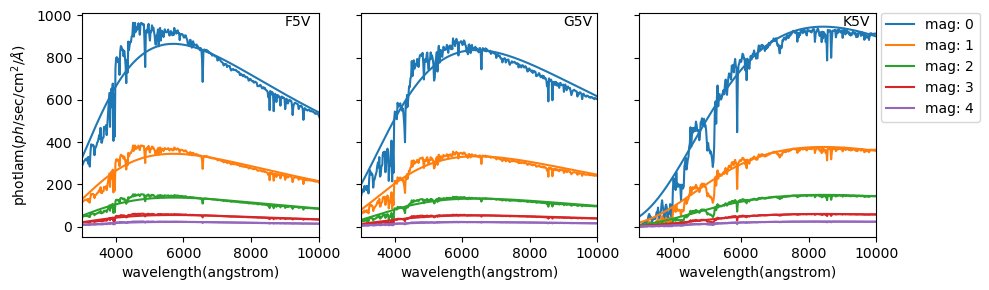

In [3]:
f, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
plt.subplots_adjust(wspace=0.05)

for ix, sptype in enumerate(['F5V', 'G5V', 'K5V']):
    for imag, mag in enumerate(range(0, 5)):
        sp = star_photlam(mag, sptype)
        spb = star_photlam(mag, sptype, is_blackbody=True)
        ax[ix].plot(sp.wave, sp.flux,
                    color=f'C{imag}', label=f'mag: {mag}')
        ax[ix].plot(spb.wave, spb.flux, color=f'C{imag}')

    ax[ix].set_xlim([3000, 10000])
    ax[ix].text(9000, 950, sptype)
    ax[ix].set_xlabel('wavelength(angstrom)')

ax[0].set_ylabel('photlam($ph$/sec/cm$^2$/$\\AA$)')
ax[2].legend(bbox_to_anchor=(1.02, 1),
                loc='upper left', borderaxespad=0)
plt.tight_layout()


## 行星光谱生成
星冕仪图像仿真程序提供了一个内置的行星模型--木星海王星混合模型(Lacy et al. 2019)。该模型通过0-1之间的两个参数（coe_b 和 coe_r）控制蓝端和红端和木星及海王星光谱的接近程度。当为1时为木星光谱，0时为海王星光谱。详见Lacy et al. 2019。下图是使用本函数对Lacy et al.文章中图6的重制。


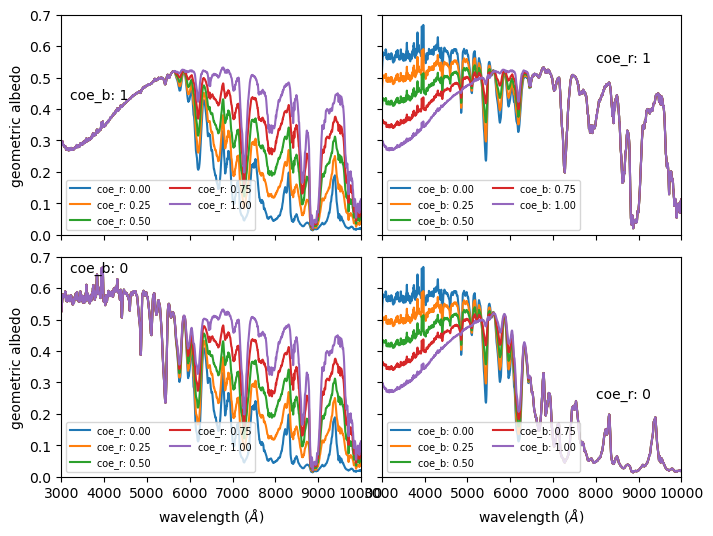

In [4]:
f, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
plt.subplots_adjust(wspace=0.07, hspace=0.1)

coe_r = 1
for coe_b in np.linspace(0, 1, 5):
    sp = hybrid_albedo_spectrum(coe_b, coe_r)
    ax[0, 1].plot(sp.wave, sp.throughput, '-', label=f'coe_b: {coe_b:.2f}')
ax[0, 1].text(8000, 0.55, 'coe_r: 1')

coe_b = 1
for coe_r in np.linspace(0, 1, 5):
    sp = hybrid_albedo_spectrum(coe_b, coe_r)
    ax[0, 0].plot(sp.wave, sp.throughput, '-', label=f'coe_r: {coe_r:.2f}')
ax[0, 0].text(3200, 0.43, 'coe_b: 1')

coe_r = 0
for coe_b in np.linspace(0, 1, 5):
    sp = hybrid_albedo_spectrum(coe_b, coe_r)
    ax[1, 1].plot(sp.wave, sp.throughput, '-', label=f'coe_b: {coe_b:.2f}')
ax[1, 1].text(8000, 0.25, 'coe_r: 0')

coe_b = 0
for coe_r in np.linspace(0, 1, 5):
    sp = hybrid_albedo_spectrum(coe_b, coe_r)
    ax[1, 0].plot(sp.wave, sp.throughput, '-', label=f'coe_r: {coe_r:.2f}')
ax[1, 0].text(3200, 0.65, 'coe_b: 0')

for i in [0, 1]:
    ax[0, i].legend(ncol=2, prop={'size': 7}, loc='lower left')
    ax[1, i].legend(ncol=2, prop={'size': 7}, loc='lower left')

    ax[1, i].set_xlim([3000, 10000])
    ax[1, i].set_xlabel('wavelength ($\\AA$)')

    ax[i, 0].set_ylim([0, 0.7])
    ax[i, 0].set_ylabel('geometric albedo')


## 行星光谱BCC模型
在程序中，我们还集成了星星光谱BCC模型，该模型参考Batalha et al. 2018提供。该模型可以生成行星的反照率谱。该反照率谱的参数包括：

- metallicity：行星的金属度，取值范围从0到2，单位为log(Z/Zsun)。
- f_sed：云层沉积效率，取值范围从-2到2，单位为log(f_sed)。fsed越大，云层越薄。

参考文献：
Batalha et al. 2018, A new model for the albedo of exoplanets, The Astrophysical Journal, 851, 1, 12


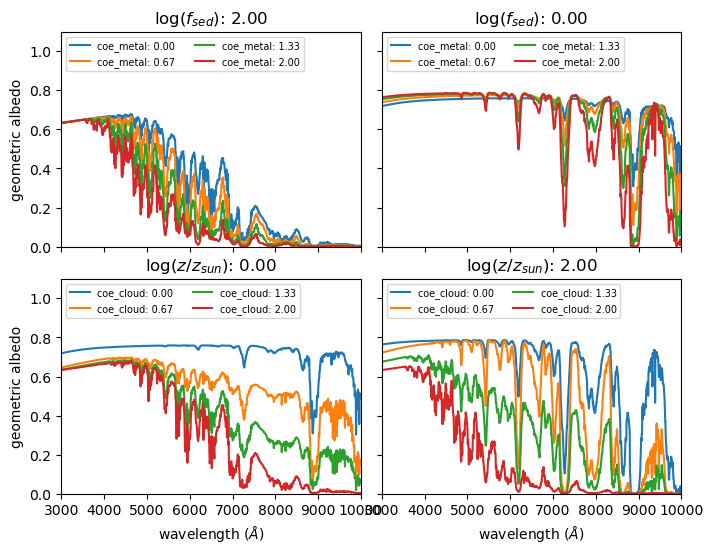

In [27]:


f, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
plt.subplots_adjust(wspace=0.07, hspace=0.15)

coe_cloud = 0
for coe_metal in np.linspace(0, 2, 4):
    sp = bcc_spectrum(coe_cloud, coe_metal)
    ax[0, 1].plot(sp.wave, sp.throughput, '-', label=f'coe_metal: {coe_metal:.2f}')
ax[0, 1].set_title(f'log($f_{{sed}}$): {coe_cloud:.2f}')

coe_cloud = 2
for coe_metal in np.linspace(0, 2, 4):
    sp = bcc_spectrum(coe_cloud, coe_metal)
    ax[0, 0].plot(sp.wave, sp.throughput, '-', label=f'coe_metal: {coe_metal:.2f}')
ax[0, 0].set_title(f'log($f_{{sed}}$): {coe_cloud:.2f}')

coe_metal = 0
for coe_cloud in np.linspace(0, 2, 4):
    sp = bcc_spectrum(coe_cloud, coe_metal)
    ax[1, 0].plot(sp.wave, sp.throughput, '-', label=f'coe_cloud: {coe_cloud:.2f}')
ax[1, 0].set_title(f'log($z/z_{{sun}}$): {coe_metal:.2f}')

coe_metal = 2
for coe_cloud in np.linspace(0, 2, 4):
    sp = bcc_spectrum(coe_cloud, coe_metal)
    ax[1, 1].plot(sp.wave, sp.throughput, '-', label=f'coe_cloud: {coe_cloud:.2f}')
ax[1, 1].set_title(f'log($z/z_{{sun}}$): {coe_metal:.2f}')

for i in [0, 1]:
    ax[0, i].legend(ncol=2, prop={'size': 7}, loc='upper left')
    ax[1, i].legend(ncol=2, prop={'size': 7}, loc='upper left')

    ax[1, i].set_xlim([3000, 10000])
    ax[1, i].set_xlabel('wavelength ($\\AA$)')

    ax[i, 0].set_ylim([0, 1.1])
    ax[i, 0].set_ylabel('geometric albedo')

## 目标位置
在程序中有两种方法指定目标的位置，1）通过目标赤道坐标，2）通过和主星的相对位置。当通过目标赤道坐标计算位置时，需要同时设置主星的赤道坐标。赤道坐标通过astropy中的SkyCoord类设置，格式为带单位的字符串，例如'30d'代表30度，'20d20m15s'代表20度20分14秒，'12h1m12s'则是以时角表示的单位。当通过和主星的相对位置设置目标位置时，需要给出目标距离主星的角距离（seperation)和方位角（pangle），其中seperation的单位为角秒，pangle的单位为度。北方向为0度，顺时针为正方向。下面的程序给出了一个例子。

(ra, dec) of center star must be provided if (ra, dec) of bkstar is used
either (ra, dec) or (pangle, separation) needed in target dict


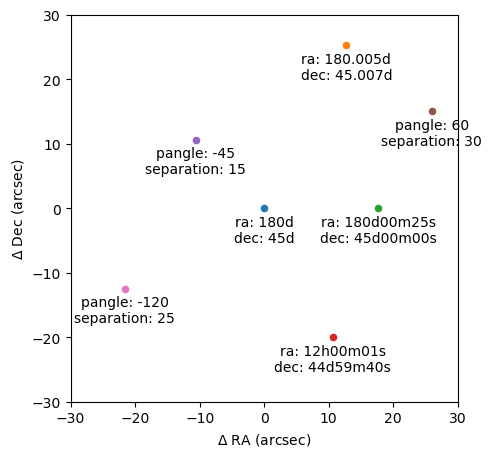

In [28]:
target_list = [
    {'ra': '180d', 'dec': '45d'},
    {'ra': '180d', 'dec': '45d'},
    {'ra': '180.01d'},
    {'ra': '180.005d', 'dec': '45.007d'},
    {'ra': '180d00m25s', 'dec': '45d00m00s'},
    {'ra': '12h00m01s', 'dec': '44d59m40s'},
    {'pangle': -45, 'separation': 15},
    {'pangle': 60, 'separation': 30},
    {'pangle': -120, 'separation': 25},
]

ra0 = None
dec0 = None
f, ax, = plt.subplots(1, 1, figsize=(5, 5))

for target in target_list:
    try:
        x, y = extract_target_x_y(target, ra0=ra0, dec0=dec0)
        plt.scatter([x], [y], 20, marker='o')

        plt.text(
            x, y-1,
            "\n".join([f"{key}: {value}" for key,
                        value in target.items()]),
            horizontalalignment='center',
            verticalalignment='top'
        )
    except ValueError as e:
        print(e)

    ra0 = target_list[0]['ra']
    dec0 = target_list[0]['dec']

plt.xlim([-30, 30])
plt.ylim([-30, 30])
plt.xlabel('$\\Delta$ RA (arcsec)')
plt.ylabel('$\\Delta$ Dec (arcsec)')
ax.set_aspect(1)
plt.tight_layout()

## 行星对比度计算
行星对比度计算函数planet_contrast可以计算行星的对比度。该函数需要输入行星的半径（单位为木星半径），行星相对恒星RA方向和DEC方向的距离（单位AU），行星的相位角。相位角指观测方向与行星-恒星连线的夹角，当观测方向与行星-恒星连线重合时，相位角为0度。当观测方向与行星-恒星连线垂直时，相位角为90度。程序会根据输入的投影距离和相位角计算行星恒星的3D物理距离。之后通过相位角计算行星的相位函数。程序中使用的相位函数为Lambert函数。之后通过公式

$$ contrast = (\frac{seperation}{distance})^2 \Theta(phase)$$

计算行星的对比度。该对比度和行星的几何反照率相乘和可以得到行星的实际对比度。
注意，相位角不可以是0度或者180度。

下面的程序给出了一个例子。我们计算了在不同椭圆轨道上的行星的对比度的变化。



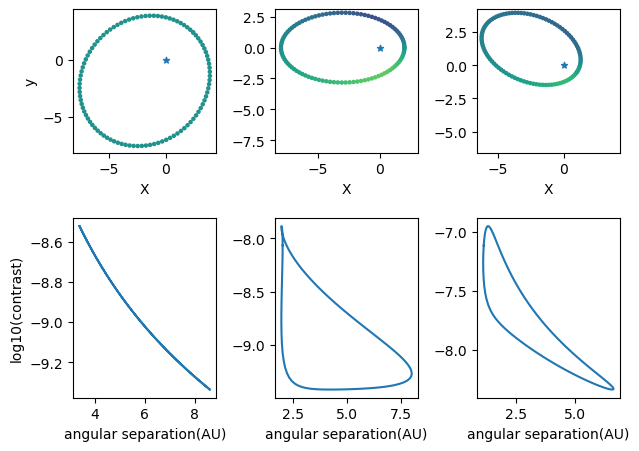

In [29]:
def orbit(a, e, i, w):

    DEG2RAD = np.pi/180
    w *= DEG2RAD
    i *= DEG2RAD
    cx = a * np.sqrt(1 - (1-e)**2)

    theta = np.linspace(0, 2*np.pi, 100)
    ox = np.cos(theta) * a - cx
    oy = np.sin(theta) * a * (1 - e)

    rx = ox * np.sin(w) + oy * np.cos(w)
    ry = ox * np.cos(w) - oy * np.sin(w)

    x = rx
    y = ry * np.sin(i)
    z = ry * np.cos(i)

    return x, y, np.arctan2(np.sqrt(x*x + y*y), z) / DEG2RAD

orbits = [
    [0.7, 6, 0.1, 90, 45],
    [0.7, 5, 0.2, 45, 90],
    [1.5, 4, 0.3, 60, 120],
]

f, ax = plt.subplots(2, len(orbits))

for ind, (radius, a, e, i, w) in enumerate(orbits):
    ax[0, ind].set_aspect(1)
    contrasts = []
    xx, yy, phases = orbit(a, e, i, w)

    for x, y, alpha in zip(xx, yy, phases):
        contrasts.append(planet_contrast(x, y, alpha, radius))

    contrasts = np.log10(np.array(contrasts))
    ax[0, ind].scatter(xx, yy, 5, c=phases, vmin=0, vmax=180)
    ax[0, ind].scatter([0], [0], 20, marker='*')
    ax[0, ind].set_xlabel('X')
    xlim = ax[0, ind].get_xlim()
    ylim = ax[0, ind].get_ylim()

    ax[0, ind].set_xlim(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax[0, ind].set_ylim(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax[0, ind].set_aspect(1)

    ax[1, ind].plot(np.sqrt(xx**2 + yy**2), contrasts)
    ax[1, ind].set_xlabel('angular separation(AU)')

ax[0, 0].set_ylabel('y')
ax[1, 0].set_ylabel('log10(contrast)')
plt.tight_layout()

## 目标参数读取和输出
本程序中使用spectrum_generator函数读取目标参数的信息，并生成所有目标的位置和光谱。

程序的输入参数为包括目标参数的字典。字典的键值为'name'指定目标名称, 'cstar'指定中心恒星的参数, 'stars'指定背景星列表，'planet'指定行星列表。 

主星需要指定星等、光谱型、RA、DEC；背景星需要指定星等、光谱型、RA及DEC或者相对主星的距离及方位角。行星需要指定半径、coe_b、coe_r、相位角、RA及DEC或者相对主星的距离及方位角。

输出为每个目标的位置和光谱的列表。位置单位为角秒，光谱为pysynphot的Spectrum类型，波长单位为$\AA$，流量单位为photlam ($ph$/sec/$cm^2$/$\AA$)。

下面的程序给出了一个例子。


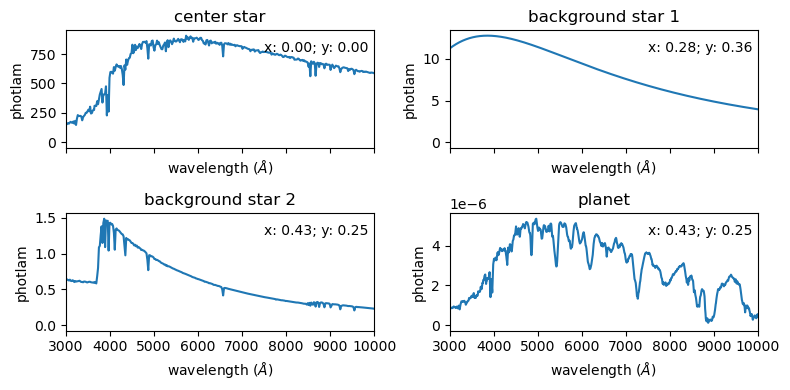

In [32]:

target = {
    'name': 'TEST1',
    'cstar': {
        'magnitude': 0,
        'ra': '120d',
        'dec': '40d',
        'distance': 10,
        'sptype': 'G0III',
    },
    'objects': [
        {
            'magnitude': 5,
            'ra': '120.0001d',
            'dec': '40.0001d',
            'sptype': 'F0III',
            'sp_model': 'blackbody'
        },
        {
            'magnitude': 8,
            'pangle': 60,
            'separation': 0.5,
            'sptype': 'A2.5II',
            'sp_model': 'star'
        },
        {
            'radius': 2,
            'pangle': 60,
            'coe_b': 0.3,
            'coe_r': 0.7,
            'separation': 0.5,
            'phase_angle': 90,
            'sp_model': 'hybrid_planet'
        }
    ]
}

names = ['center star', 'background star 1', 'background star 2', 'planet']

sps = spectrum_generator(target)
f, ax = plt.subplots(2, 2, figsize=(8, 4), sharex=True)
for ind, sp in enumerate(sps):
    x, y, spobj, image = sp
    plt.subplot(2, 2, ind+1)
    plt.title(names[ind])
    plt.plot(spobj.wave, spobj.flux)
    plt.xlim([3000, 10000])
    plt.text(7500, max(spobj.flux)*0.85, f"x: {x:.2f}; y: {y:.2f}")
    plt.ylabel('photlam')
    plt.xlabel('wavelength ($\\AA$)')

plt.tight_layout()

## 